<a href="https://colab.research.google.com/github/logikon-ai/cot-eval/blob/main/notebooks/CoT_Leaderboard_Results_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the `/\/` Open CoT Leaderboard Results

## Setup

### Init

In [1]:
%pip install -Uq datasets huggingface_hub seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.5/388.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


In [1]:
EVAL_DATASET = "cot-leaderboard/cot-eval-results"
TRACES_DATASET = "cot-leaderboard/cot-eval-traces-2.0"
LOCAL_DIR = "cot-eval-results"
LOCAL_CONFIGS = "cot-traces"
SUBSETS = ["base","cot","orig"]

In [ ]:
import getpass
from huggingface_hub import HfApi, login

HF_TOKEN = getpass.getpass("HF Token:")
API = HfApi(token=HF_TOKEN)
login(HF_TOKEN, add_to_git_credential=True)

In [ ]:
#!rm -r cot-eval-results
#!rm -r cot-traces

### Load evaluation results

In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id=EVAL_DATASET,
    revision="main",
    local_dir=LOCAL_DIR,
    repo_type="dataset",
    max_workers=60,
    token=HF_TOKEN
)


In [4]:
# get all models for which results are stored
import glob

models = []
for path in glob.glob(f"{LOCAL_DIR}/data/*/*", recursive=False):
  models.append(path.replace(f"{LOCAL_DIR}/data/",""))
models

['google/gemma-2b-it',
 'google/gemma-2b',
 'meta-llama/Llama-2-70b-chat-hf',
 'meta-llama/Llama-2-7b-hf',
 'meta-llama/Llama-2-13b-hf',
 'meta-llama/Llama-2-13b-chat-hf',
 'meta-llama/Llama-2-70b-hf',
 'Intel/neural-chat-7b-v3-1',
 'NousResearch/Nous-Hermes-llama-2-7b',
 'openchat/openchat-3.5-0106',
 'microsoft/phi-2',
 'allenai/tulu-2-13b',
 'allenai/tulu-2-dpo-13b',
 'allenai/tulu-2-7b',
 'allenai/tulu-2-70b',
 'allenai/tulu-2-dpo-70b',
 'allenai/tulu-2-dpo-7b',
 'databricks/dolly-v2-3b',
 'Deci/DeciLM-7B',
 'Deci/DeciLM-7B-instruct',
 'mistralai/Mistral-7B-Instruct-v0.2',
 'mistralai/Mistral-7B-v0.1',
 'HuggingFaceH4/zephyr-7b-beta',
 '01-ai/Yi-6B',
 'teknium/OpenHermes-2.5-Mistral-7B']

In [5]:
import json

import pandas as pd

results = []

for model in models:
    for subset in SUBSETS:
        result_files = glob.glob(f"{LOCAL_DIR}/data/{model}/{subset}/**/*.json", recursive=True)
        for json_filepath in result_files:
            with open(json_filepath) as fp:
                data = json.load(fp)
            if "results" in data.keys():
                for k,v in data["results"].items():
                    record = v.copy()
                    record["model"] = model
                    record["subset"] = subset
                    results.append(record)

df_results = pd.DataFrame(results)
del results

In [6]:
def split_alias(alias: str) -> pd.Series:
    if alias[-5:]=="_base":
        alias = alias[:-5]
    elif alias[-4:]=="_cot":
        alias = alias[:-4]

    if "_" not in alias:
        task = alias
        config = ""
    else:
        config, task = alias.split("_")

    return pd.Series({"task": task, "config": config})

df_results = pd.concat([df_results, df_results.alias.apply(split_alias)], axis=1)

In [29]:
df_results.head()

,"acc,none","acc_stderr,none",alias,model,subset,task,config
0,0.277354,0.011295,ipsum-suscipit-6540_logiqa2_base,google/gemma-2b-it,base,logiqa2,ipsum-suscipit-6540
1,0.255591,0.017448,ipsum-suscipit-6540_logiqa_base,google/gemma-2b-it,base,logiqa,ipsum-suscipit-6540
2,0.191304,0.025992,ipsum-suscipit-6540_lsat-ar_base,google/gemma-2b-it,base,lsat-ar,ipsum-suscipit-6540
3,0.215686,0.018230,ipsum-suscipit-6540_lsat-lr_base,google/gemma-2b-it,base,lsat-lr,ipsum-suscipit-6540
4,0.256506,0.026676,ipsum-suscipit-6540_lsat-rc_base,google/gemma-2b-it,base,lsat-rc,ipsum-suscipit-6540


In [ ]:
df_baseline = df_results[df_results.subset.eq("base")].groupby(["model","task"])[["acc,none"]].mean()
df_baseline.head()

In [17]:
df_tmp1 = df_results[df_results.subset.eq("cot")].sort_values(by=["model","task","config"])

df_tmp1.reset_index(inplace=True, drop=True)

df_cot = df_tmp1[["model","task","config"]].copy()
df_cot["acc_cot"] = df_tmp1["acc,none"]
df_cot["acc_base"] = df_cot.apply(lambda row: df_baseline.loc[(row.model, row.task)]["acc,none"], axis=1)

df_cot["delta_abs"] = df_cot.acc_cot - df_cot.acc_base
df_cot["delta_rel"] = (df_cot.acc_cot - df_cot.acc_base)/df_cot.acc_base


In [18]:
df_cot.head()

,model,task,config,acc_cot,acc_base,delta_abs,delta_rel
0,01-ai/Yi-6B,logiqa,accusantium-inventore,0.327476,0.282748,0.044728,0.158192
1,01-ai/Yi-6B,logiqa,amet-ullam,0.292332,0.282748,0.009585,0.033898
2,01-ai/Yi-6B,logiqa,illum-eaque,0.292332,0.282748,0.009585,0.033898
3,01-ai/Yi-6B,logiqa,libero-exercitationem,0.321086,0.282748,0.038339,0.135593
4,01-ai/Yi-6B,logiqa,magnam-eius,0.290735,0.282748,0.007987,0.028249


In [19]:
df_cot.groupby("model").count()["task"]

model
01-ai/Yi-6B                            30
Deci/DeciLM-7B                         30
Deci/DeciLM-7B-instruct                30
HuggingFaceH4/zephyr-7b-beta           30
Intel/neural-chat-7b-v3-1              30
NousResearch/Nous-Hermes-llama-2-7b    30
allenai/tulu-2-13b                     30
allenai/tulu-2-70b                     30
allenai/tulu-2-7b                      30
allenai/tulu-2-dpo-13b                 30
allenai/tulu-2-dpo-70b                 30
allenai/tulu-2-dpo-7b                  30
databricks/dolly-v2-3b                 30
google/gemma-2b                        30
google/gemma-2b-it                     30
meta-llama/Llama-2-13b-chat-hf         30
meta-llama/Llama-2-13b-hf              30
meta-llama/Llama-2-70b-chat-hf         30
meta-llama/Llama-2-70b-hf              30
meta-llama/Llama-2-7b-hf               30
microsoft/phi-2                        30
mistralai/Mistral-7B-Instruct-v0.2     30
mistralai/Mistral-7B-v0.1              30
openchat/openchat-3.5-0106  

### Load CoT configuration data

In [22]:
import datasets

df_cottraces = pd.DataFrame(datasets.load_dataset(TRACES_DATASET)["test"])
df_cotconfigs = pd.DataFrame([
    dict(data) for data
    in df_cottraces.config_data
    if data
])
df_cotconfigs.drop_duplicates(inplace=True, ignore_index=True)
df_cotconfigs

In [23]:
# add cot configs data to df_results
def select_config_data(row):
    df_selected = df_cotconfigs[df_cotconfigs.name.eq(row.config) & df_cotconfigs.model.eq(row.model)]
    if len(df_selected) == 0:
        print(f"Config {row.config} not found for model {row.model}")
        return None
    if len(df_selected) > 1:
        print(f"Multiple configs found for {row.config} for model {row.model}")
        return None
    return df_selected.drop(columns=["name", "model"]).iloc[0]


df_cot = pd.concat(
    [
        df_cot,
        df_cot.apply(select_config_data, axis=1)
    ],
    axis=1
)


In [24]:
df_cot["decoding"] = "T:"+df_cot.temperature.astype(str) + "-BS:" + df_cot.use_beam_search.astype(str)

In [25]:
df_cot.head()

,model,task,config,acc_cot,acc_base,delta_abs,delta_rel,cot_chain,best_of,temperature,top_k,top_p,use_beam_search,decoding
0,01-ai/Yi-6B,logiqa,accusantium-inventore,0.327476,0.282748,0.044728,0.158192,HandsOn,1,0,-1,1.0,false,T:0-BS:false
1,01-ai/Yi-6B,logiqa,amet-ullam,0.292332,0.282748,0.009585,0.033898,ReflectBeforeRun,2,0,-1,1.0,true,T:0-BS:true
2,01-ai/Yi-6B,logiqa,illum-eaque,0.292332,0.282748,0.009585,0.033898,ReflectBeforeRun,1,0.3,100,0.95,false,T:0.3-BS:false
3,01-ai/Yi-6B,logiqa,libero-exercitationem,0.321086,0.282748,0.038339,0.135593,HandsOn,2,0,-1,1.0,true,T:0-BS:true
4,01-ai/Yi-6B,logiqa,magnam-eius,0.290735,0.282748,0.007987,0.028249,HandsOn,1,0.3,100,0.95,false,T:0.3-BS:false


## Exploration

#### CoT Accuracy Gains for Models and Tasks

(Averaged over all regimes.)

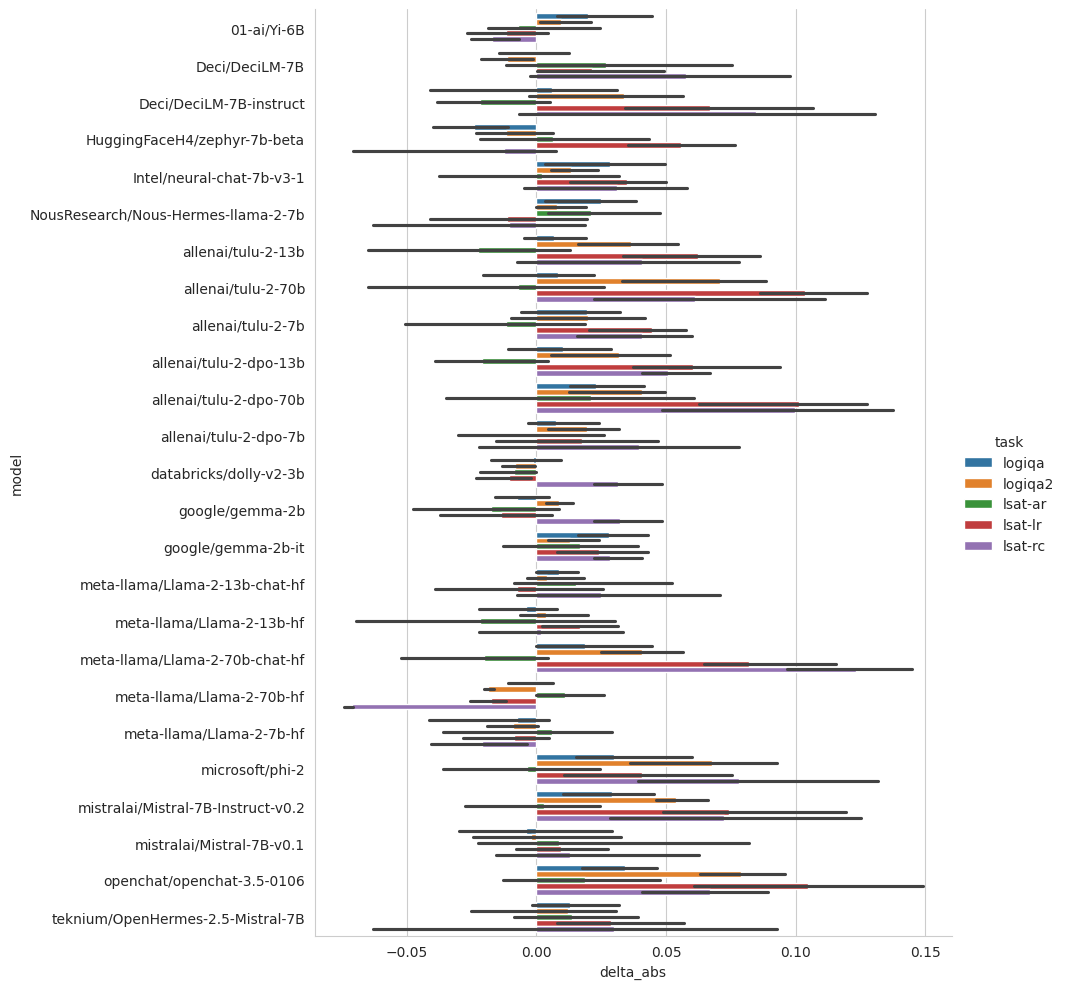

In [36]:
import seaborn as sns

sns.set_style("whitegrid")

sns.catplot(data=df_cot, hue="task", y="model", x="delta_abs", kind="bar", errorbar=("pi", 100), height=10, aspect=1)

#### CoT Accuracy Gains as a Function of Base Accuracy

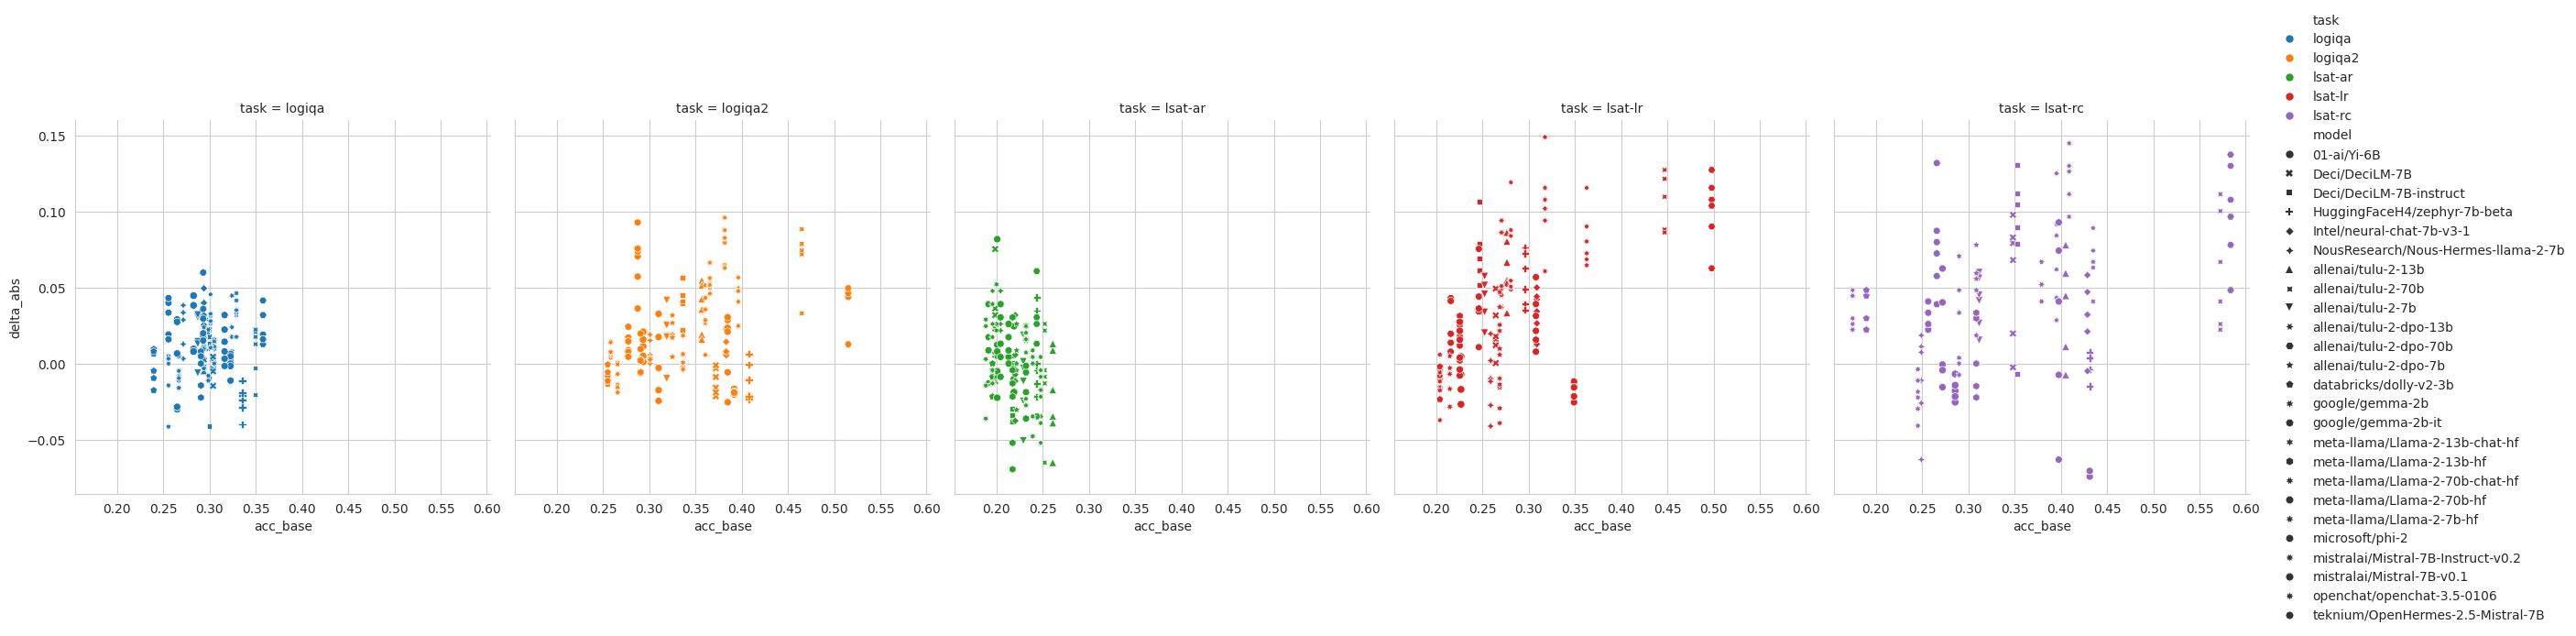

In [27]:
sns.relplot(data=df_cot, col="task", hue="task", style="model", y="delta_abs", x="acc_base", kind="scatter")

#### CoT Accuracy Gains as a Function of Reasoning Regime

(Averaged over all models.)

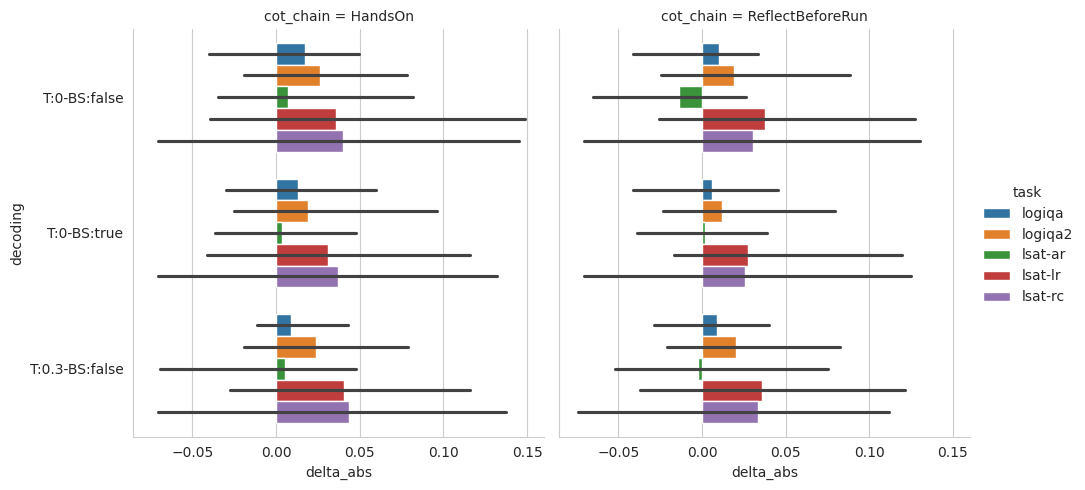

In [28]:
sns.catplot(data=df_cot, hue="task", y="decoding", x="delta_abs", kind="bar", errorbar=("pi", 100), col="cot_chain")